Strategy Overview: does headquater location of a company from a fast growing city provide a better return than the S&P 500 

In [14]:
import pandas as pd
import yfinance as yf
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np

Data Collection: Top 10 companies by marketcap headquatered in each of the 5 fastest growing cities in America by GDP

In [15]:
startDate = "2019-01-01"
endDate = "2025-12-31"

stockTickers = [
    ["TSLA", "ORCL", "DELL", "CRWD", "DLR", "BSY", "SLAB", "YETI", "CRUS", "NXPI"], #Austin
    #["DELL", "NATI", "ACC", "PE", "SWI", "SLAB", "REZI", "SAIL", "CRUS", "QTWO"], #Austin (nonbiased selection)
    ["MSFT", "AMZN", "COST", "TMUS", "SBUX", "PCAR", "FTV", "EXPE", "Z", "ALK"], #Seattle
    ["V", "WFC", "CRM", "UBER", "PLD", "DASH", "ABNB", "PINS", "OKTA", "TWLO"], #San Francisco
    ["HCA", "TSCO", "DG", "RHP", "PNFP", "ACHC", "LPX", "FBK", "DK", "CYH"], #Nashville
    ["IQV", "MLM", "FCNCA", "AAP", "HIW", "SKT", "ACT", "WOLF", "BAND", "ITIC"] #Raleigh-Durham
]

benchmarkData = yf.download("^GSPC", start=startDate, end=endDate)

allData = {}
cityNames = ["Austin", "Seattle", "San Francisco", "Nashville", "Raleigh-Durham"]


[*********************100%***********************]  1 of 1 completed


Download company data and compute S&P 500 returns

In [16]:
benchmarkData = yf.download("^GSPC", start=startDate, end=endDate)

allData = {}
cityNames = ["Austin", "Seattle", "San Francisco", "Nashville", "Raleigh-Durham"]

for i, cityList in enumerate(stockTickers):
    print(f"Downloading data for {cityNames[i]}")
    
    data = yf.download(cityList, start=startDate, end=endDate, group_by='ticker')
    
    allData[cityNames[i]] = data


sp500Start = benchmarkData['Close'].iloc[0]
sp500End = benchmarkData['Close'].iloc[-1]
totalSp500Return = ((sp500End / sp500Start) - 1) * 100
print(totalSp500Return)
city_cumulative_results = {}


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  10 of 10 completed


[*********************100%***********************]  10 of 10 completed


[*********************100%***********************]  10 of 10 completed


[*********************100%***********************]  10 of 10 completed


[*********************100%***********************]  10 of 10 completed

Ticker
^GSPC    174.74732
dtype: float64


compute cumulative return and beta on company data selection

In [17]:
for city in cityNames:
    closes = allData[city].xs('Close', axis=1, level=1)
    daily_pct_change = closes.pct_change()
    portfolio_daily_return = daily_pct_change.mean(axis=1)
    cumulative_growth = (1 + portfolio_daily_return.dropna()).prod()
    total_return_pct = (cumulative_growth - 1) * 100
    city_cumulative_results[city] = total_return_pct
    print(f"{city}: Return {total_return_pct:.2f}%")
sp500DailyReturns = benchmarkData['Close'].pct_change()

for city in cityNames:
    cityCloses = allData[city].xs('Close', axis=1, level=1)
    cityAvgDaily = cityCloses.pct_change().mean(axis=1)
    allignedData = pd.concat([cityAvgDaily, sp500DailyReturns], axis=1).dropna()
    matrix = np.cov(allignedData.iloc[:, 0], allignedData.iloc[:, 1])
    cityBeta = matrix[0, 1] / matrix[1, 1]
    print(f"{city} Beta: {cityBeta:.2f}")



Austin: Return 535.46%
Seattle: Return 227.29%
San Francisco: Return 215.73%
Nashville: Return 209.76%
Raleigh-Durham: Return 146.46%
Austin Beta: 1.31
Seattle Beta: 1.06
San Francisco Beta: 1.24
Nashville Beta: 1.10
Raleigh-Durham Beta: 1.04


calculate sharpe ratio

In [18]:
rf_annual = 0.03
rf_daily = rf_annual / 252
portfoliosDailyReturns = {}

for city in cityNames:
    cityCloses = allData[city].xs('Close', axis = 1, level=1)
    portfoliosDailyReturns[city] = cityCloses.pct_change().mean(axis=1)

allCityReturns = pd.concat([portfoliosDailyReturns[city] for city in cityNames], axis=1)
portfoliosDailyReturns['CombinedCityPort'] = allCityReturns.mean(axis=1)

portfoliosDailyReturns['S&P_500'] = benchmarkData['Close'].pct_change()

print(f"\n{'Portfolio':<20} | {'Annualized Sharpe Ratio':<25}")
print("-" * 50)

for name, returns in portfoliosDailyReturns.items():
    clean_returns = returns.dropna()
    
    avg_daily_ret = clean_returns.mean()
    std_daily_ret = clean_returns.std()

    m = avg_daily_ret.squeeze() if hasattr(avg_daily_ret, 'squeeze') else avg_daily_ret
    s = std_daily_ret.squeeze() if hasattr(std_daily_ret, 'squeeze') else std_daily_ret

    sharpe = ((m - rf_daily) / s) * np.sqrt(252)
    
    print(f"{name:<20} | {sharpe:>25.4f}")



Portfolio            | Annualized Sharpe Ratio  
--------------------------------------------------
Austin               |                    0.9271
Seattle              |                    0.7126
San Francisco        |                    0.5877
Nashville            |                    0.5900
Raleigh-Durham       |                    0.5088
CombinedCityPort     |                    0.7533
S&P_500              |                    0.6763


calculate sector exposure

In [19]:

flat_tickers = [ticker for sublist in stockTickers for ticker in sublist]
sector_map = {}

for ticker in flat_tickers:
    try:
        info = yf.Ticker(ticker).info
        sector = info.get('sector', 'Unknown')
        sector_map[ticker] = sector
    except Exception:
        sector_map[ticker] = "Unknown"
city_sector_exposure = {}

for i, city in enumerate(cityNames):
    tickers_in_city = stockTickers[i]
    sectors = [sector_map[t] for t in tickers_in_city]
    counts = pd.Series(sectors).value_counts(normalize=True) * 100
    city_sector_exposure[city] = counts
all_sectors = [sector_map[t] for t in flat_tickers]
combined_exposure = pd.Series(all_sectors).value_counts(normalize=True) * 100

print("\n--- SECTOR EXPOSURE PER CITY (%) ---")
for city, exposure in city_sector_exposure.items():
    print(f"\n{city}:")
    print(exposure.to_string())

print("\n--- COMBINED PORTFOLIO SECTOR EXPOSURE (%) ---")
print(combined_exposure.to_string())



--- SECTOR EXPOSURE PER CITY (%) ---

Austin:
Technology           70.0
Consumer Cyclical    20.0
Real Estate          10.0

Seattle:
Consumer Cyclical         30.0
Technology                20.0
Communication Services    20.0
Industrials               20.0
Consumer Defensive        10.0

San Francisco:
Technology                40.0
Financial Services        20.0
Consumer Cyclical         20.0
Real Estate               10.0
Communication Services    10.0

Nashville:
Healthcare            30.0
Financial Services    20.0
Consumer Cyclical     10.0
Consumer Defensive    10.0
Real Estate           10.0
Industrials           10.0
Energy                10.0

Raleigh-Durham:
Financial Services    30.0
Real Estate           20.0
Technology            20.0
Healthcare            10.0
Basic Materials       10.0
Consumer Cyclical     10.0

--- COMBINED PORTFOLIO SECTOR EXPOSURE (%) ---
Technology                30.0
Consumer Cyclical         18.0
Financial Services        14.0
Real Estate       

Clean data and prep graphs

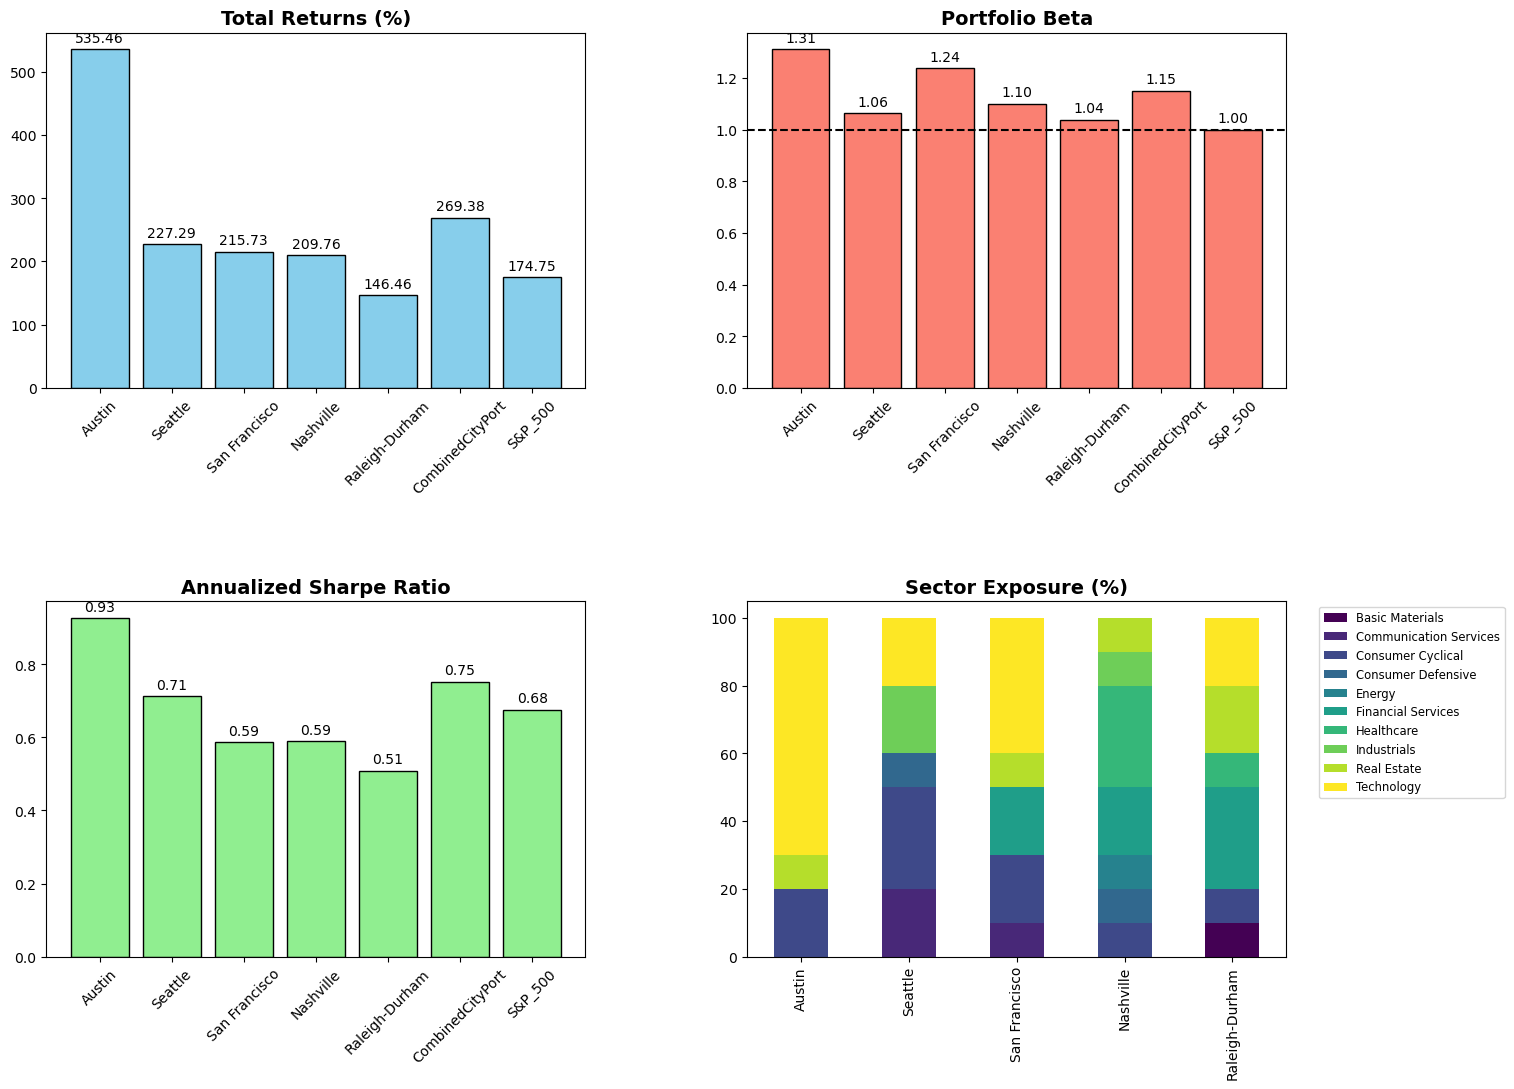

In [20]:

portfolios = list(portfoliosDailyReturns.keys())
returns_list = []
betas_list = []
sharpe_list = []

for name in portfolios:
    clean_ret = portfoliosDailyReturns[name].dropna()

    avg_daily = clean_ret.mean()
    std_daily = clean_ret.std()
    sr = ((avg_daily - rf_daily) / std_daily) * np.sqrt(252)
    
    if isinstance(sr, (pd.Series, pd.DataFrame)):
        sharpe_list.append(float(sr.iloc[0]))
    else:
        sharpe_list.append(float(sr))
    
    total_ret = ((clean_ret + 1).prod() - 1) * 100
    if isinstance(total_ret, (pd.Series, pd.DataFrame)):
        returns_list.append(float(total_ret.iloc[0]))
    else:
        returns_list.append(float(total_ret))
    
    if name == 'S&P_500':
        betas_list.append(1.0)
    else:
        aligned = pd.concat([clean_ret, portfoliosDailyReturns['S&P_500']], axis=1, sort=False).dropna()
        cov_matrix = np.cov(aligned.iloc[:, 0], aligned.iloc[:, 1])
        beta = cov_matrix[0, 1] / cov_matrix[1, 1]
        betas_list.append(float(beta))


fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.6, wspace=0.3)

def add_labels(ax):
    for rect in ax.patches:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

axes[0, 0].bar(portfolios, returns_list, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Total Returns (%)', fontsize=14, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
add_labels(axes[0, 0])

axes[0, 1].bar(portfolios, betas_list, color='salmon', edgecolor='black')
axes[0, 1].axhline(1.0, color='black', linestyle='--', label='Market Risk (1.0)')
axes[0, 1].set_title('Portfolio Beta', fontsize=14, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
add_labels(axes[0, 1])

axes[1, 0].bar(portfolios, sharpe_list, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Annualized Sharpe Ratio', fontsize=14, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
add_labels(axes[1, 0])

exposure_df = pd.DataFrame(city_sector_exposure).T
exposure_df.plot(kind='bar', stacked=True, ax=axes[1, 1], colormap='viridis')
axes[1, 1].set_title('Sector Exposure (%)', fontsize=14, fontweight='bold')
axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')


Print Individual stock performance

In [21]:
print("\nINDIVIDUAL STOCK PERFORMANCE (Total Return %)")

for city in cityNames:
    print(f"\n--- {city.upper()} ---")
    city_closes = allData[city].xs('Close', axis=1, level=1)
    
    for ticker in city_closes.columns:
        first_price = city_closes[ticker].iloc[0]
        last_price = city_closes[ticker].iloc[-1]
        stock_return = ((last_price / first_price) - 1) * 100
        
        print(f"{ticker:<8}: {stock_return:>10.2f}%")


INDIVIDUAL STOCK PERFORMANCE (Total Return %)

--- AUSTIN ---
BSY     :        nan%
YETI    :     174.03%
TSLA    :    2098.00%
DLR     :      93.02%
CRWD    :        nan%
SLAB    :      67.71%
CRUS    :     251.43%
NXPI    :     228.01%
ORCL    :     383.90%
DELL    :     484.28%

--- SEATTLE ---
AMZN    :     202.16%
Z       :     128.53%
SBUX    :      54.24%
FTV     :      35.58%
COST    :     366.95%
ALK     :     -16.25%
TMUS    :     223.25%
EXPE    :     160.48%
MSFT    :     415.24%
PCAR    :     271.92%

--- SAN FRANCISCO ---
ABNB    :        nan%
TWLO    :      65.74%
DASH    :        nan%
PINS    :        nan%
CRM     :      98.56%
PLD     :     174.21%
UBER    :        nan%
V       :     179.34%
OKTA    :      38.21%
WFC     :     143.91%

--- NASHVILLE ---
ACHC    :     -43.50%
CYH     :       0.32%
FBK     :      75.83%
HCA     :     313.20%
RHP     :      79.78%
TSCO    :     241.07%
LPX     :     332.40%
PNFP    :     127.52%
DG      :      38.38%
DK      :      14.76